#**Phase 1 Milestone 2 Assignment**

##**Identity**

Ihsan Aulia Rahman

Full Time Data Science

HCK-Batch-001

#**A. Description**

##**A.1. Problem Statement**

Wine  is one of the most influental culture in the world. The wine industry is valued at US$ 339.53 billion in 2020. Nowadays wine is not just a beverage but also a luxury item, with sommeliers checking sure the quality and valuing the bottles. But what if the process could be automated with machine learning? 

##**A.2. Objective**

The goal of this project is to build a classify model to assign grades on wine samples based on their sensory data.

#**B. Libraries**

Here we import the necessary function libraries for this assignment.

##**B.1. Exploratory Functions**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# Create histogram and box plots of a column
def plot_hist_box(df, variable):
  plt.figure(figsize=(16, 4))
  plt.subplot(1, 2, 1)
  sns.histplot(df[variable], bins=40)
  plt.title('Histogram')
  plt.subplot(1, 2, 2)
  sns.boxplot(y=df[variable])
  plt.title('Boxplot')
  plt.show()

# Create bar plot of a column
def plot_bar(df, variable):
  plt.figure(figsize=(10, 4))
  sns.barplot(data = df, x = df[variable].unique(), y = df[variable].value_counts())
  plt.title('Category Distribution')
  plt.show()

# Return upper and lower boundary values of a column 
def boundaries(df,variable):
  skewness = df[variable].skew()
  if skewness>=-0.5 and skewness<=0.5:
    upper = df[variable].mean() + 3*df[variable].std()
    lower = df[variable].mean() - 3*df[variable].std()
  else:
    Q1 = df[variable].quantile(0.25)
    Q3 = df[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q1 + 1.5*IQR
    lower = Q3 - 1.5*IQR
  return upper, lower

# Return outlier statistics
def outliers(df, variable, multiplier, upper_boundary, lower_boundary):
  print('Number of data : {}'.format(len(df)))
  print('Upper Outlier  : {}'.format(len(df[df[variable] > upper_boundary])))
  print('Lower Outlier  : {}'.format(len(df[df[variable] < lower_boundary])))
  print('Total Outlier  : {}'.format(len(df[(df[variable] > upper_boundary)]) + len(df[(df[variable] < lower_boundary)])))
  print('% outlier : {} %'.format((len(df[(df[variable] > upper_boundary)]) + len(df[(df[variable] < lower_boundary)])) / len(df) * 100))

def outlier_analysis(df,col):
  skewness = df[col].skew()
  if skewness>=-0.5 and skewness<=0.5:
    upper = df[col].mean() + 3*df[col].std()
    lower = df[col].mean() - 3*df[col].std()
  else:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q1 + 1.5*IQR
    lower = Q3 - 1.5*IQR
  not_outliers = df[(df[col]>=lower) & (df[col]<=upper)]
  outliers = df[(df[col]<lower) | (df[col]>upper)]
  return outliers,not_outliers, upper, lower

##**B.2. Modelling Functions**

In [2]:
# Split and Standarize Datasets
from sklearn.model_selection import train_test_split
!pip install feature-engine
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Hyperparameter Optimizer
from sklearn.model_selection import GridSearchCV

# Evaluate Classification Models
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Save Model Files
import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 5.4 MB/s 


#**C. Loading and EDA**

##**C.1. Data Loading**

The data we are using for our training and testing is the wine grading dataset from Kaggle :

https://www.kaggle.com/datasets/shelvigarg/wine-quality-dataset

In [3]:
ds = pd.read_csv('https://raw.githubusercontent.com/IARahman/GA3-Files/main/winequalityN.csv')
pd.set_option('display.max.columns', None)

##**C.2. Exploratory Data Analysis**

Let's have a look:

In [4]:
ds[ds.quality == 9]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
774,white,9.1,0.27,0.45,10.6,0.035,28.0,124.0,0.99700,3.20,0.46,10.4,9
820,white,6.6,0.36,0.29,1.6,0.021,24.0,85.0,0.98965,3.41,0.61,12.4,9
827,white,7.4,0.24,0.36,2.0,0.031,27.0,139.0,0.99055,3.28,0.48,12.5,9
876,white,6.9,0.36,0.34,4.2,0.018,57.0,119.0,0.98980,3.28,0.36,12.7,9
1605,white,7.1,0.26,0.49,2.2,0.032,31.0,113.0,0.99030,3.37,0.42,12.9,9


In [5]:
ds.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
ds.tail(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
6496,red,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [7]:
ds.shape

(6497, 13)

* `type` `_________________`: Wine type (red, white)
* `fixed acidity` `________`: Tartaric acid (gram / liter)
* `volatile acidity` `_____`: Acetic acid (gram / liter)
* `citric acid` `__________`: Citric acid (gram / liter)
* `residual sugar` `_______`: Residual sugar (gram / liter)
* `chlorides ` `____________`: Natrium Chloride (gram / liter)
* `free sulfur dioxide` `__`: Free Sulphur Dioxide (miligram / liter)
* `total sulfur dioxide` `_`: Free and bound Sulphur Dioxide (miligram / liter)
* `density` `______________`: Density (gram / mililiter)
* `pH` `___________________`: Acidity (pH)
* `sulphates` `____________`: Kalium Sulphate (gram / liter)
* `alcohol` `______________`: Alcohol content (%)
* `quality` `______________`: Grade of the wine (1 to 10)

The dataframe has 6497 observations with 13 variables. Only 1 of them is categorical and the rest are numerical.

We are going to use column `quality ` as our prediction target. The numeric grade will be reduced into category grade.

Let's have a deeper look at the dataset through statistics.

In [8]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [ ]:
ds.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


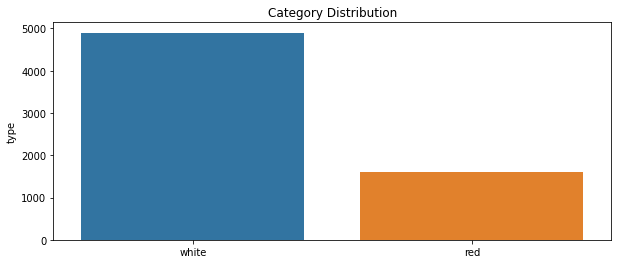

In [ ]:
plot_bar(ds, 'type')

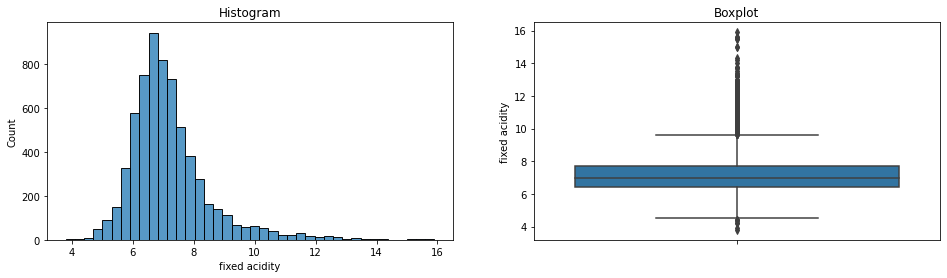


Skewness Value :  1.7228045308969795
Variable is skewed
Number of data : 6497
Upper Outlier  : 860
Lower Outlier  : 394
Total Outlier  : 1254
% outlier : 19.30121594582115 %


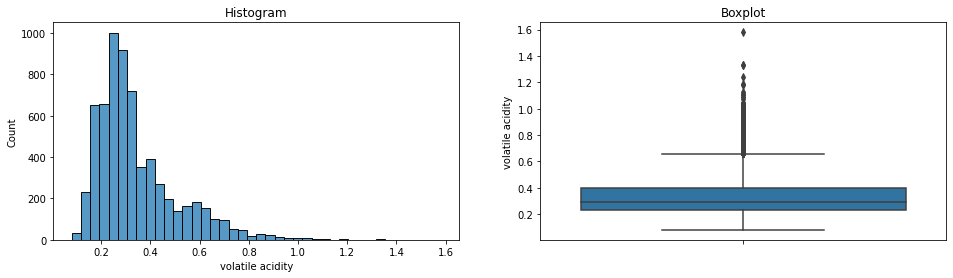


Skewness Value :  1.4955115856471894
Variable is skewed
Number of data : 6497
Upper Outlier  : 1106
Lower Outlier  : 178
Total Outlier  : 1284
% outlier : 19.762967523472373 %


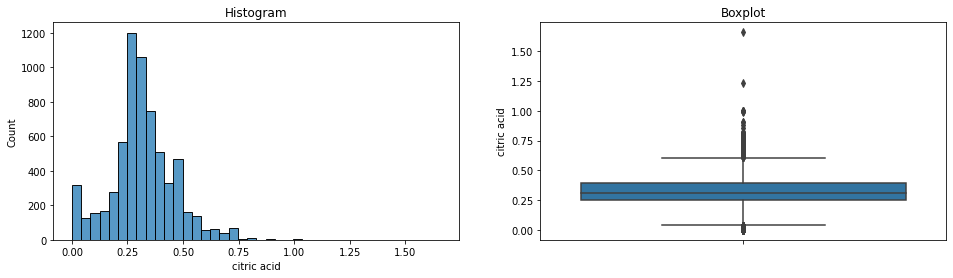


Skewness Value :  0.4730324266140668
Variable is not skewed
Number of data : 6497
Upper Outlier  : 28
Lower Outlier  : 0
Total Outlier  : 28
% outlier : 0.43096813914114207 %


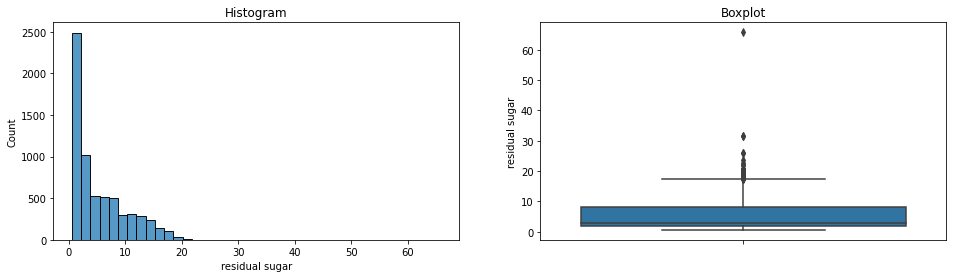


Skewness Value :  1.4349998392718966
Variable is skewed
Number of data : 6497
Upper Outlier  : 969
Lower Outlier  : 0
Total Outlier  : 969
% outlier : 14.914575958134524 %


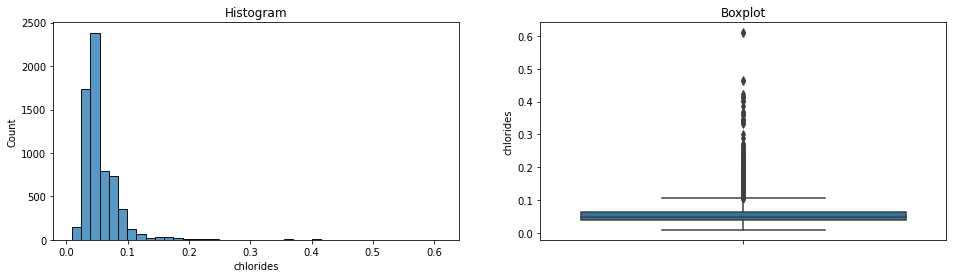


Skewness Value :  5.399848762544374
Variable is skewed
Number of data : 6497
Upper Outlier  : 1006
Lower Outlier  : 149
Total Outlier  : 1155
% outlier : 17.77743573957211 %


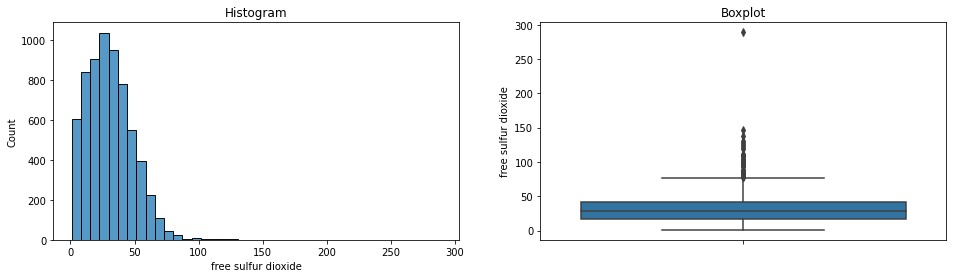


Skewness Value :  1.2200660740665203
Variable is skewed
Number of data : 6497
Upper Outlier  : 675
Lower Outlier  : 116
Total Outlier  : 791
% outlier : 12.174849930737263 %


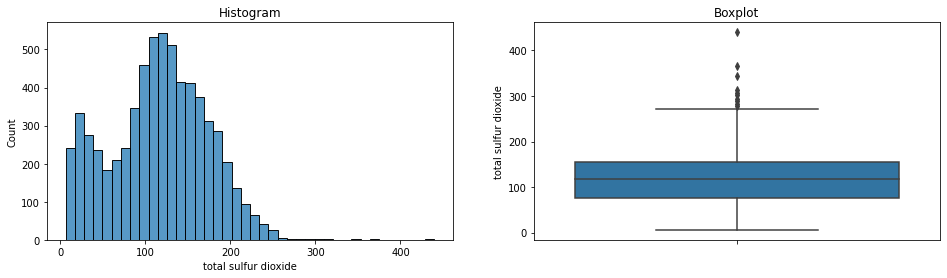


Skewness Value :  -0.001177478234437964
Variable is not skewed
Number of data : 6497
Upper Outlier  : 8
Lower Outlier  : 0
Total Outlier  : 8
% outlier : 0.12313375404032631 %


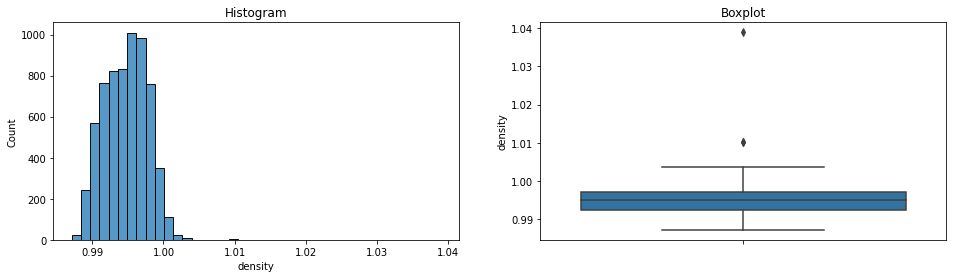


Skewness Value :  0.5036017301419994
Variable is skewed
Number of data : 6497
Upper Outlier  : 331
Lower Outlier  : 375
Total Outlier  : 706
% outlier : 10.866553794058795 %


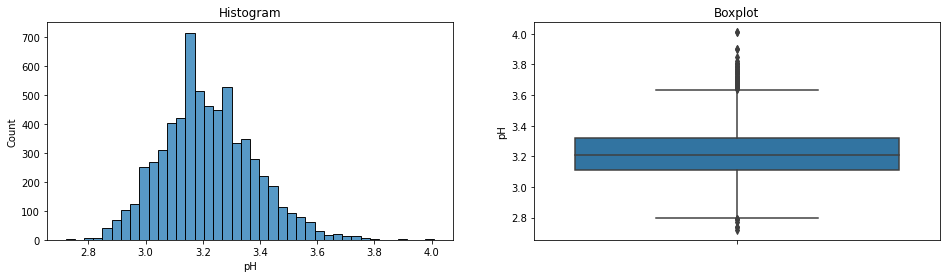


Skewness Value :  0.3869659325699095
Variable is not skewed
Number of data : 6497
Upper Outlier  : 32
Lower Outlier  : 1
Total Outlier  : 33
% outlier : 0.507926735416346 %


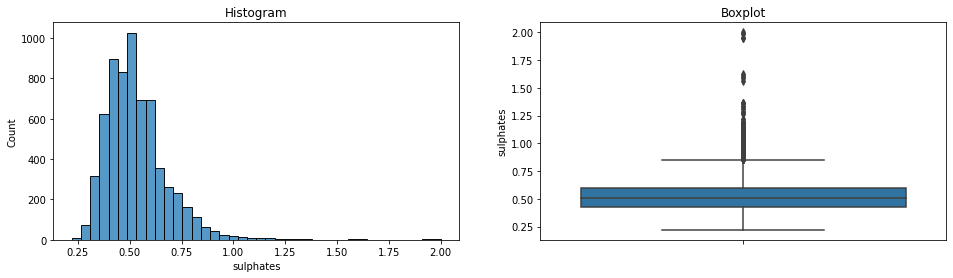


Skewness Value :  1.798467034111248
Variable is skewed
Number of data : 6497
Upper Outlier  : 825
Lower Outlier  : 316
Total Outlier  : 1141
% outlier : 17.561951670001537 %


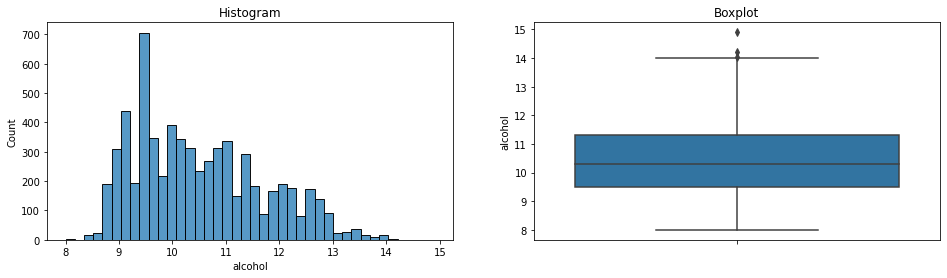


Skewness Value :  0.5657177290960251
Variable is skewed
Number of data : 6497
Upper Outlier  : 686
Lower Outlier  : 17
Total Outlier  : 703
% outlier : 10.820378636293675 %


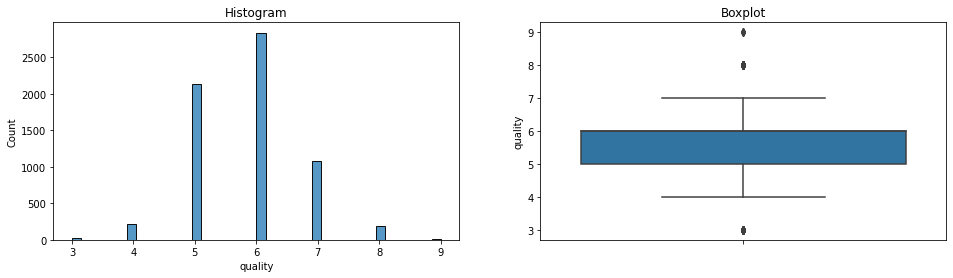


Skewness Value :  0.1896226933726968
Variable is not skewed
Number of data : 6497
Upper Outlier  : 5
Lower Outlier  : 30
Total Outlier  : 35
% outlier : 0.5387101739264276 %


In [ ]:
num_cols = np.array(ds.columns).tolist()
num_cols.remove('type')

for n in num_cols:
  plot_hist_box(ds, n)
  skewness = ds[n].skew()
  print('\nSkewness Value : ', skewness)
  if ds[n].skew() >=-0.5 and ds[n].skew() <0.5:
    print(f'Variable is not skewed')
  else:
    print(f'Variable is skewed')
  upper_boundary, lower_boundary = boundaries(ds, n)
  outliers(ds, n, 1.5, upper_boundary, lower_boundary)

There are considerable outliers in our dataset. For that, we are going to use winsorizer later on.

##**C.3. Cleaning**

We need to make sure the data is wholly clean of duplicates and missing values .

In [ ]:
ds.duplicated().sum()

1168

In [ ]:
ds.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

The duplicates take quite significant portion (a sixth of total data) but we will just drop them since they're of no use. The missing values however, are insignificant compared to thousands of data, so we will drop them too.

In [9]:
df = ds.copy()
df.drop(ds[ds.duplicated()].index, inplace=True)
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.quality = pd.cut(df.quality, bins=[2.5, 4.5, 6.5, 8.5, 10.5],labels=['Low','Medium','High','Excellent'])

#**D. Pipeline Assembly**

After EDA and cleaning, we can proceed to building the preprocessing and model pipelines. 

##**D.1. Data Splitting**

We need to split the data first for our model building.

In [11]:
X = df.drop('quality', axis=1) 
Y = df['quality']

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11092001)

In [13]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist() 

##**D.2. Preprocessing**

We build the base pipelines to be incorporated into the complete preprocessing pipeline.

In [14]:
cat_enc = Pipeline(steps=[('ohe_enc', OneHotEncoder(handle_unknown='ignore'))])

In [15]:
num_win = Pipeline(steps=[('winsorizer', Winsorizer(capping_method='iqr', tail='both', fold=1.5)),
                          ('scaler', StandardScaler())])

Now, it's a simple assembly using Column Transformer function.

In [16]:
prep_win = ColumnTransformer(
    transformers=[('cat', cat_enc, cat_cols),
                  ('num', num_win, num_cols)])

##**D.3. Modelling**

We are going to build 5 different classifier models with their parameters grid: 
* Polynomial Logistic 
* Polynomial Support Vector
* Radial Support Vector
* Decision Tree
* Adaptive Boosting. 

We will then test them on train-test models with Grid Search Cross Validation and choose the best one for our final pipeline.

In [17]:
pipe = Pipeline([('preprocessing', prep_win), ('classifier', SVC())])

In [18]:
param_grid = [{'preprocessing': [prep_win], #polynomial Logistic 
               'classifier': [Pipeline([('polynomial', PolynomialFeatures()), ('logreg', LogisticRegression())])], 
               'classifier__polynomial__degree': [1, 2, 3, 4],
               'classifier__logreg__C': [0.01, 0.1, 1, 10, 100]},
              {'preprocessing': [prep_win], #Linear SVC
               'classifier': [SVC(kernel='poly', probability=True)],  
               'classifier__degree': [1, 2, 3, 4],
               'classifier__C': [0.01, 0.1, 1, 10, 100]},
              {'preprocessing': [prep_win], #Polynommial SVC
               'classifier': [SVC(kernel='rbf', probability=True)],
               'classifier__gamma': [0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.01, 0.1, 1, 10, 100]},
              {'preprocessing': [prep_win], #Decision Tree
               'classifier': [DecisionTreeClassifier()],
               'classifier__max_depth': [1, 2, 3]},
              {'preprocessing': [prep_win], #Adaptive Boosting
               'classifier': [AdaBoostClassifier()], 
               'classifier__n_estimators': [50, 100, 200],
               'classifier__learning_rate': [0.1, 0.5, 1]}]

In [19]:
grid = GridSearchCV(pipe, param_grid, cv=4)
grid.fit(X_train, Y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, Y_test)))

Best params:
{'classifier': SVC(C=10, gamma=0.1, probability=True), 'classifier__C': 10, 'classifier__gamma': 0.1, 'preprocessing': ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('ohe_enc',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['type']),
                                ('num',
                                 Pipeline(steps=[('winsorizer',
                                                  Winsorizer(capping_method='iqr',
                                                             fold=1.5,
                                                             tail='both')),
                                                 ('scaler', StandardScaler())]),
                                 ['fixed acidity', 'volatile acidity',
                                  'citric acid', 'residual sugar', 'chlorides',
                                  'free sulfur dioxide', 'total 

The best classifier model is Radial Support Vector with C=10 and Gamma=0.1.

It scored 80% on the training cross validated dataset and 78% on test dataset.

Very good for a multiclass classifier.

Now we just need to build a final, end-to-end preprocessing and prediction pipeline from that hyperparameters.

In [ ]:
Wine_Classifier = Pipeline([('preprocessing', prep_win), ('classifier', SVC(kernel='rbf', C=10, gamma=0.1, probability=True))])
Wine_Classifier.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ohe_enc',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type']),
                                                 ('num',
                                                  Pipeline(steps=[('winsorizer',
                                                                   Winsorizer(capping_method='iqr',
                                                                              fold=1.5,
                                                                              tail='both')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fixed acidity',
        

#**E. Deployment**

After we build the final pipeline, we can download it in pickle format using this prompt.

In [ ]:
pickle.dump(Wine_Classifier, open('Wine_Classifier.pkl', 'wb'))

The pickle format is then bundled with support files in a web app folder.

#**F. Analysis**

Using pipeline function, we can simplify an entire preprocessing and prediction process in one pickle file. It also automate testing many combinations of preprocessing, model and hyperparameters in a single click. 

Using a web app, we can make our model more user-friendly. The only thing we need to do to use the model is to input information and the whole process takes over in the background.